In [2]:
import numpy as np
from matplotlib import pyplot as plt
import camb
import time
import pickle
import progressbar
import corner

## Problem 2 (questions 2-5)

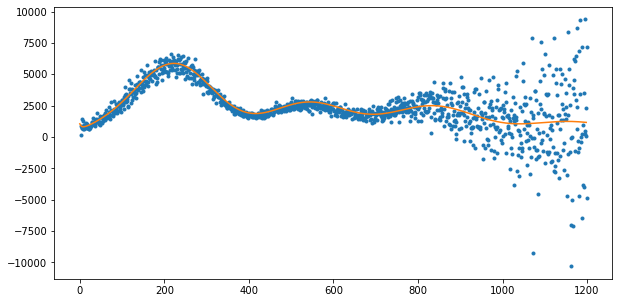

In [3]:
def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()  #instance of the object storing the parameters for a CAMB calculation
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)  #Sets cosmological parameters in terms of physical densities and parameters
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)  # CMB power spectra will be accurate to the chosen l_max
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[2:1201,0]   
    return tt

link = "https://raw.githubusercontent.com/sievers/phys512-2020/master/problem_sets/wmap_tt_spectrum_9yr_v5.txt"
wmap=np.loadtxt(link, usecols=[0,1,2])
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])  #H0, barion dens, dark matter dens, optical depth, amplitude, slope 
plt.figure(figsize=[10,5])
plt.plot(wmap[:,0],wmap[:,1],'.')
cmb=get_spectrum(pars); plt.plot(cmb)
plt.show()

In [4]:
labels = ['H0', 'ombh2', 'omchh2', 'tau', 'As', 'ns'] # set the labels for parameters that we will be using everywhere

### 2) $\chi^2$

We will only be using priors for $\tau$, so it can simply be included as a parameter for chifun. tau_limits sets a prior with a sharp step-like distribution (outside of these limits $\chi^2$ is set to be very large, so the model is extremely unlikely). tau_prior will be used for Gaussian prior distributions, with tau_prior = (tau mean, tau variance).  

In [5]:
def chifun(y, noise, pars, tau_limits = (-100,100), tau_prior = None):    
    if pars[3] < tau_limits[0] or pars[3] > tau_limits[1]:
        return 1e+15
    model = get_spectrum(pars)
    chisq = np.sum((y-model)**2/noise**2)
    if tau_prior is not None:
        chisq += (pars[3]-tau_prior[0])**2/tau_prior[1]**2
    return chisq

print(chifun(wmap[:,1],wmap[:,2], pars))

1588.2376532931526


### 3) Newton's method

Firstly, we need the numerical derivatives of the CMB spectrum.

In [6]:
def spectrum_deriv(pars,dp, i):
    deriv = np.zeros([len(cmb),1])
    pars_mod = pars.copy()
    pars_mod[i] = pars[i] + dp
    right= get_spectrum(pars_mod)
    pars_mod[i] = pars[i] - dp
    left = get_spectrum(pars_mod)
    deriv = (right-left)/(2*dp)
    return deriv

def all_derivs(pars, dpar):
    derivs = np.zeros([len(cmb),len(pars)])
    for ind in range(len(pars)):
        derivs[:,ind] = spectrum_deriv(pars, dpar[ind], ind)
    return derivs

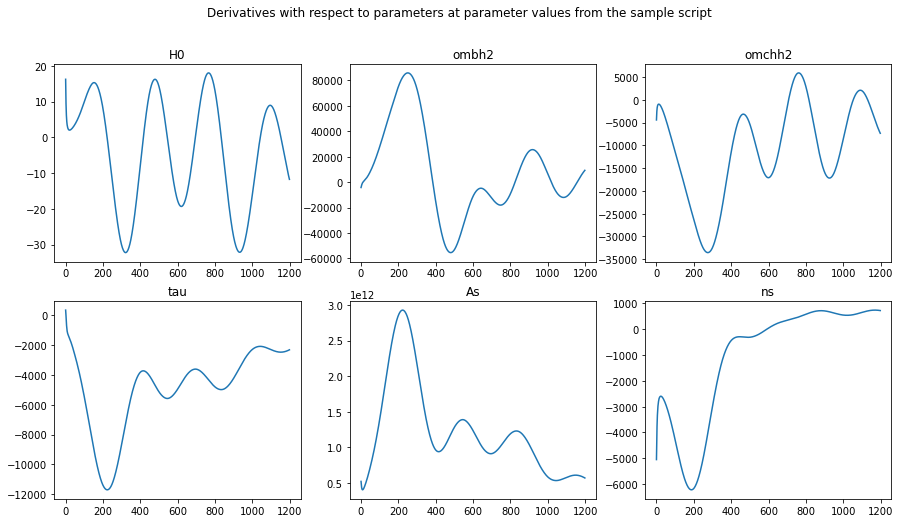

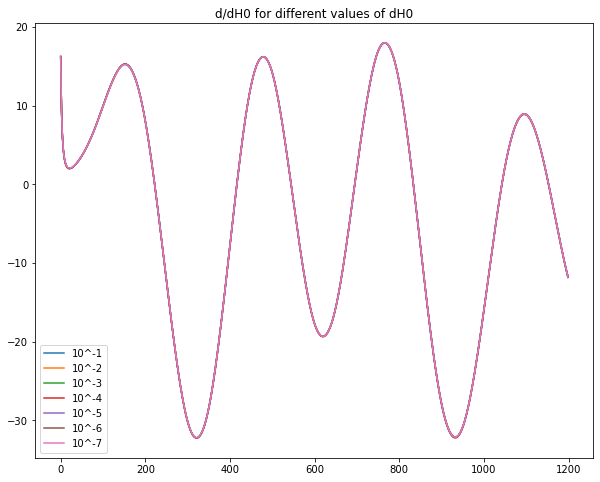

In [33]:
# make some plots for derivatives

dpar = [1e-2, 1e-4, 1e-3, 1e-4, 1e-11, 1e-2]
derivs = all_derivs(pars, dpar)

fig, ax = plt.subplots(2,3, figsize = (15,8))
for i in range(len(pars)):
    ax.flatten()[i].plot(derivs[:, i])
    ax.flatten()[i].set_title(labels[i])
fig.suptitle('Derivatives with respect to parameters at parameter values from the sample script')
plt.show()

dHexp = np.arange(1,9,1)
Hderiv = np.zeros([len(cmb),len(dHexp)])
plt.figure(figsize = (10,8))
for i,exp in enumerate(dHexp):
    Hderiv[:,i] = spectrum_deriv(pars, 10.**(-exp),0)
for i in range(len(dHexp)-1): #-Hderiv[:,-1]
    plt.plot(Hderiv[:,i], label = '10^-'+str(dHexp[i]))
plt.legend()
plt.title('d/dH0 for different values of dH0') 
plt.show()

In [6]:
# Newton's optimization
def Newtons(y, noise, start_pars, par_indices, dpar, niters = 10):
    Ninv=np.eye(len(y))/noise**2
    current_pars = start_pars.copy()
    print('Starting with pars ', current_pars)
    current_chisq = chifun(y, noise, start_pars)
    for iter in range(niters):
        print('')
        print("Iteration ", iter)
        model = get_spectrum(current_pars)
        resid = y - model
        derivs = np.zeros((len(model),len(par_indices)))
        for ind in range(len(par_indices)):
            par_ind = par_indices[ind]
            derivs[:,ind] = spectrum_deriv(current_pars, dpar[par_ind], par_ind)
        lhs = derivs.T@Ninv@derivs
        rhs = derivs.T@Ninv@resid
        lhs_inv = np.linalg.inv(lhs)
        step = lhs_inv@rhs
        full_step = np.zeros(len(start_pars))
        full_step[par_indices] = step
        current_pars += full_step
        print('Taking step ',full_step)
        new_chisq = chifun(y, noise, current_pars)
        delta_chisq = current_chisq - new_chisq
        current_chisq = new_chisq
        print('delta chi2 = ', -delta_chisq)
        print('Resulting pars ', current_pars)
        if delta_chisq < 0.005:
            break     
    cov = lhs_inv
    par_sigs = np.sqrt(np.diag(cov))
    print('')
    print('Best-fit values ', current_pars)
    print('Par errors ',par_sigs)
    return current_pars, par_sigs, cov

In [100]:
### keeping depth constant 
pars = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
dpar = [1e-2, 1e-4, 1e-3, 1e-4, 1e-11, 1e-2]
pars_to_vary = [0,1,2,4,5]
newt1_pars, newt1_errors, cov5 = Newtons(wmap[:,1], wmap[:,2], pars, pars_to_vary, dpar)

Starting with pars  [6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]

Iteration  0
Taking step  [2.33827009e+00 2.45761800e-03 1.62093418e-02 0.00000000e+00
 6.92297309e-11 6.46866281e-03]
delta chi2 =  -353.39441936441744
Resulting pars  [6.73382701e+01 2.24576180e-02 1.16209342e-01 5.00000000e-02
 2.06922973e-09 9.66468663e-01]

Iteration  1
Taking step  [ 1.93843633e+00  3.45252758e-05 -2.20037763e-03  0.00000000e+00
 -2.59765872e-11  3.24620900e-03]
delta chi2 =  -6.906296222816991
Resulting pars  [6.92767064e+01 2.24921433e-02 1.14008964e-01 5.00000000e-02
 2.04325314e-09 9.69714872e-01]

Iteration  2
Taking step  [ 5.39901909e-02 -5.05277380e-07 -1.04709914e-04  0.00000000e+00
 -8.00218948e-13  6.59266788e-05]
delta chi2 =  -0.0013022391315189452
Resulting pars  [6.93306966e+01 2.24916380e-02 1.13904254e-01 5.00000000e-02
 2.04245292e-09 9.69780798e-01]

Best-fit values  [6.93306966e+01 2.24916380e-02 1.13904254e-01 5.00000000e-02
 2.04245292e-09 9.69780798e-01]
Par errors  [2.3

In [101]:
#### now varying depth only
pars_to_vary = [3]
newt2_pars, newt2_errors, tausig = Newtons(wmap[:,1], wmap[:,2], newt1_pars, pars_to_vary, dpar)

Starting with pars  [6.93306966e+01 2.24916380e-02 1.13904254e-01 5.00000000e-02
 2.04245292e-09 9.69780798e-01]

Iteration  0
Taking step  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.85038648e-06
  0.00000000e+00  0.00000000e+00]
delta chi2 =  -1.0427156666992232e-06
Resulting pars  [6.93306966e+01 2.24916380e-02 1.13904254e-01 4.99981496e-02
 2.04245292e-09 9.69780798e-01]

Best-fit values  [6.93306966e+01 2.24916380e-02 1.13904254e-01 4.99981496e-02
 2.04245292e-09 9.69780798e-01]
Par errors  [0.00183418]


If we only float $\tau$ with all the other parameters optimized, it does not go far from the starting point, so we are at a constrained minimum of $\chi^2$. With all the parameters unconstrained, theoretically, we could find a lower minimum of $\chi^2$. 


As for the parameter errors, we expect them to be of the same order when varying all 6 parameters. That is why we can use the covariance matrix evaluated with fixed $\tau$ + the value of $\tau$ error estimated in-place to estimate step sizes for the MCMC algorithm.


We do not actually apply Newton's method to all 6 parameters, as that would require a modification to take into account physical constraints on $\tau$ ($\tau$ > 0).


### 4)

In [7]:
def mcmc(y, noise, pars, cov, nstep = 10000, tau_limits = (0, 100), tau_prior = None):
    npar = len(pars)
    chain = np.zeros([nstep,npar])
    chivec = np.zeros(nstep)
    L = np.linalg.cholesky(cov)
    chi_cur = chifun(y,noise,pars, tau_limits, tau_prior)
#     accept = 0              
    for i in progressbar.progressbar(range(nstep)):
        step = np.dot(L, np.random.randn(L.shape[0])) # draw a correlated step vector for 5 parameters
        # we could either add a single diagonal element for tau into the covariance matrix \
        # or insert an element for tau step into the step vector:
        step = np.insert(step, 3, tausig*np.random.randn(1))  
        pars_trial = pars + step
        chi_trial = chifun(y,noise,pars_trial, tau_limits, tau_prior)
        delta_chi = chi_trial - chi_cur
        if delta_chi < 0:  # if there is an improvement - accept the step
#             accept += 1        
            pars = pars_trial
            chi_cur = chi_trial
        elif np.random.rand(1) < np.exp(-0.5*delta_chi): # if not, only do so with some probability
#             accept += 1              
            pars=pars_trial
            chi_cur = chi_trial
        chain[i,:] = pars
        chivec[i] = chi_cur
#     print(accept, ' steps accepted')   # this was used to check the acceptance rate with short chains
    return chain,chivec

In [72]:
chain1, chivec1 = mcmc(wmap[:,1], wmap[:,2], newt1_pars, cov5, nstep = 15000)
pickle.dump(chain1, open('chain1.p', 'wb'))
pickle.dump(chivec1, open('chivec1.p', 'wb'))

100% (15000 of 15000) |##################| Elapsed Time: 7:55:20 Time:  7:55:20


To check convergence of a single chain, we can use Fourier power spectrum and chain autocorrelation:

In [8]:
def plot_ft(chain):
    fig, ax = plt.subplots(2,3, figsize = (15,8))
    for i in range(chain.shape[1]):
        result = np.abs(np.fft.rfft(chain[:,i]))
        ax.flatten()[i].loglog(result) 
        ax.flatten()[i].set_title(labels[i])
    fig.suptitle('Fourier power spectrum')
    plt.show()
        
def plot_autocorr(chain):
    fig, ax = plt.subplots(2,3, figsize = (15,8))
    for i in range(chain.shape[1]):
        result = np.correlate(chain[:,i]-np.mean(chain[:,i]), chain[:,i]-np.mean(chain[:,i]), mode = 'full') 
        maxcorr = np.argmax(result)
        ax.flatten()[i].plot((result/result[maxcorr])[chain.shape[0]-1:])  
        ax.flatten()[i].axhline(y = 0, color='r')
        ax.flatten()[i].set_title(labels[i])
    fig.suptitle('Chain autocorrelation')
    plt.show()
    
def print_results(chain, drop = None): # this function is for printing chain statistics
    par_mean = np.mean(chain, axis = 0)
    par_std = np.std(chain1, axis = 0)
    par_limits = np.zeros((chain.shape[1],2))
    for i in range(chain.shape[1]):
        vec = chain[:,i].copy()
        vec.sort()
        limits = (vec[int(0.025*len(vec))],vec[int(0.975*len(vec))]) # 95% confidence interval
        par_limits[i,:] = limits#f"{:.3e}"
        if i != drop:
            print(labels[i],'| mean:',float('%.3e'% par_mean[i]), ', std:',float('%.3e'% par_std[i]), ', parameter limits:', [float('%.3e'% v) for v in limits])    

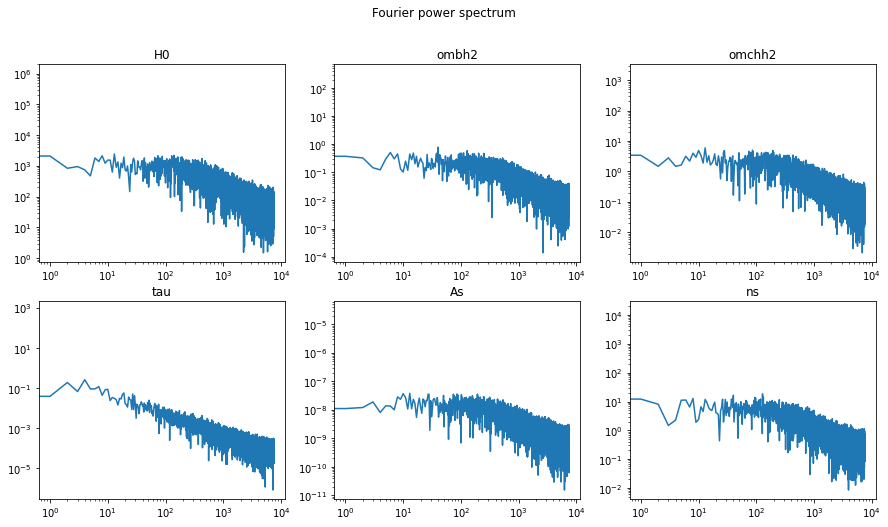

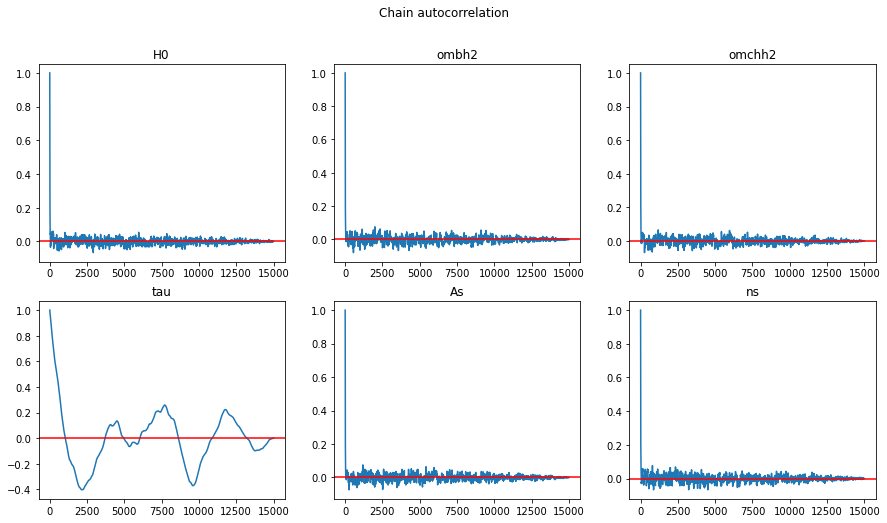

In [73]:
plot_ft(chain1)
plot_autocorr(chain1)

For converged chains, we expect the loglog plot of the Fourier spectrum to level off in the left half of the plot; we also expect the autocorrelations to drop to zero for time lag (in steps) < chain length.


What we see here is that the $\tau$ chain is unconverged, the rest of the parameters look OK. 

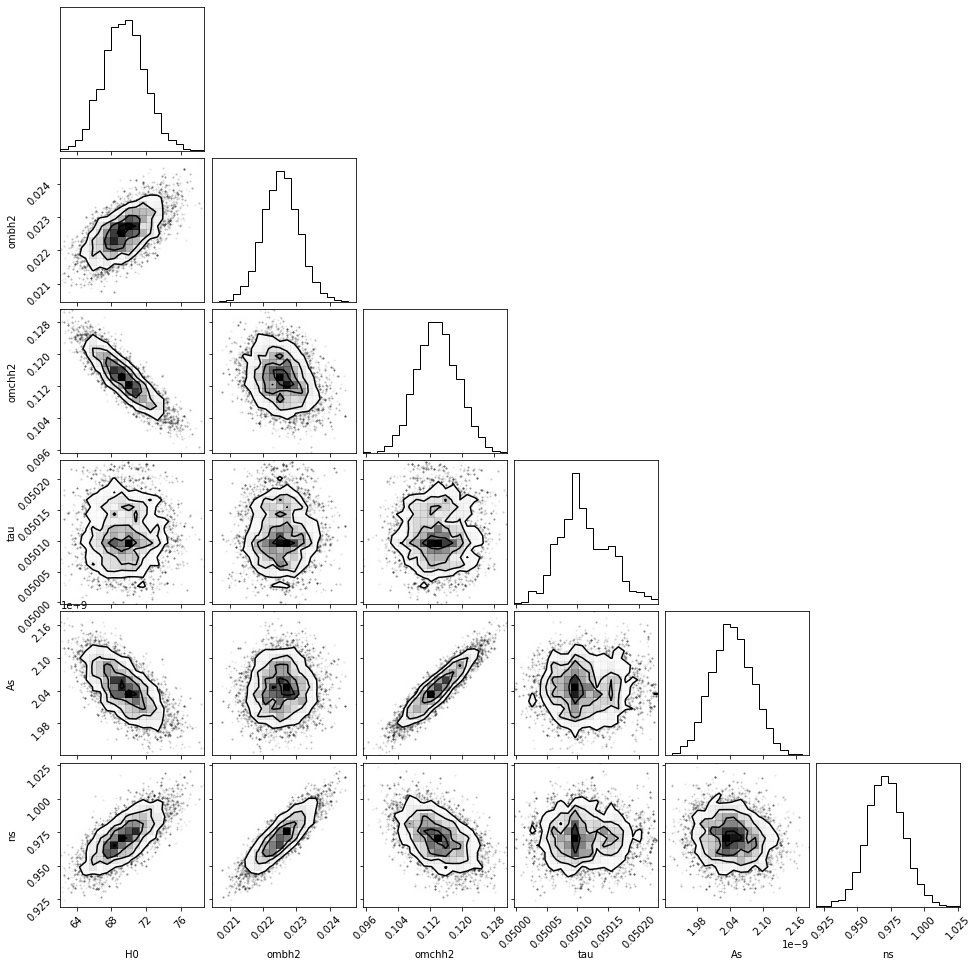

In [74]:
### corner plot the results
figure = corner.corner(chain1, labels = labels)
plt.show()

In [75]:
print_results(chain1)

H0 | mean: 69.51 , std: 2.392 , parameter limits: [65.01, 74.44]
ombh2 | mean: 0.02254 , std: 0.0005456 , parameter limits: [0.02148, 0.02363]
omchh2 | mean: 0.1139 , std: 0.005125 , parameter limits: [0.1039, 0.1242]
tau | mean: 0.05011 , std: 4.083e-05 , parameter limits: [0.05004, 0.0502]
As | mean: 2.043e-09 , std: 3.748e-11 , parameter limits: [1.972e-09, 2.117e-09]
ns | mean: 0.9711 , std: 0.01395 , parameter limits: [0.944, 0.9994]


### 5)

In [63]:
chain2, chivec2 = mcmc(wmap[:,1], wmap[:,2], newt1_pars, cov5, nstep = 15000, tau_prior = (0.0544,0.0073))
pickle.dump(chain2, open('chain2.p', 'wb'))
pickle.dump(chivec2, open('chivec2.p', 'wb'))

100% (15000 of 15000) |##################| Elapsed Time: 7:53:41 Time:  7:53:41


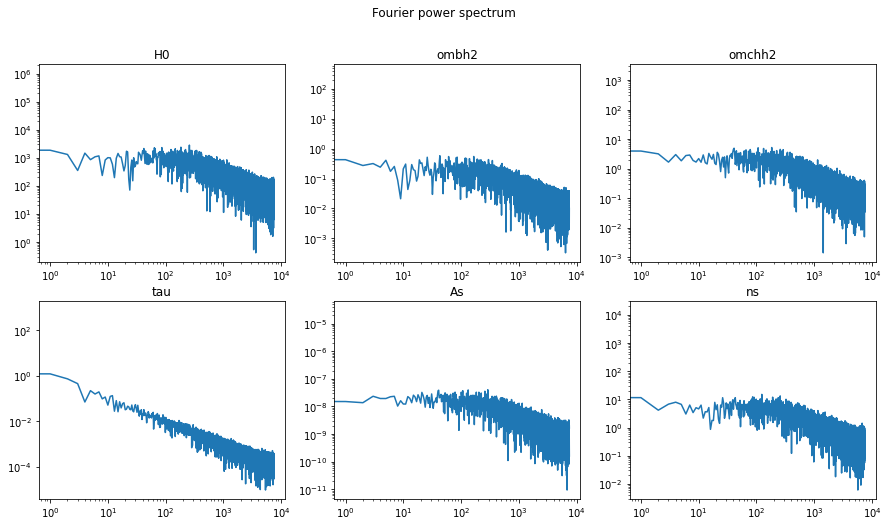

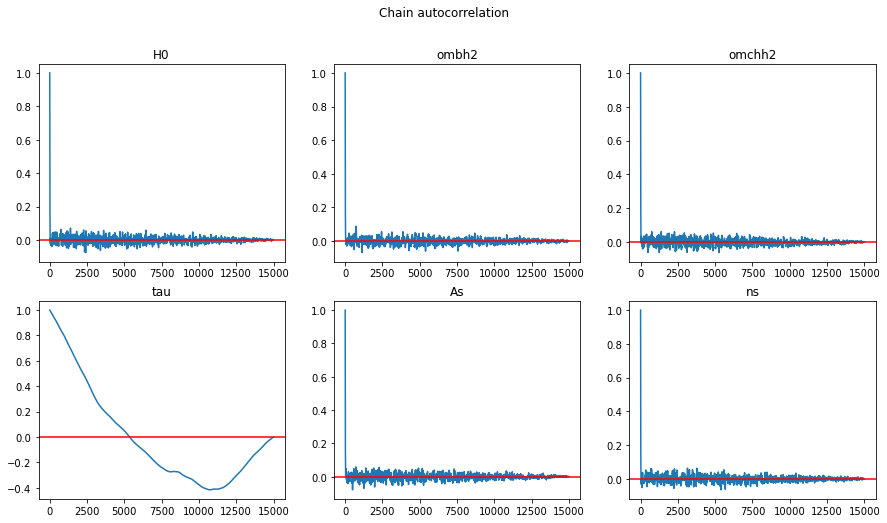

In [102]:
plot_ft(chain2)
plot_autocorr(chain2)

For the chain convergence, we have the same situation as in (4); tau convergence is even worse. 

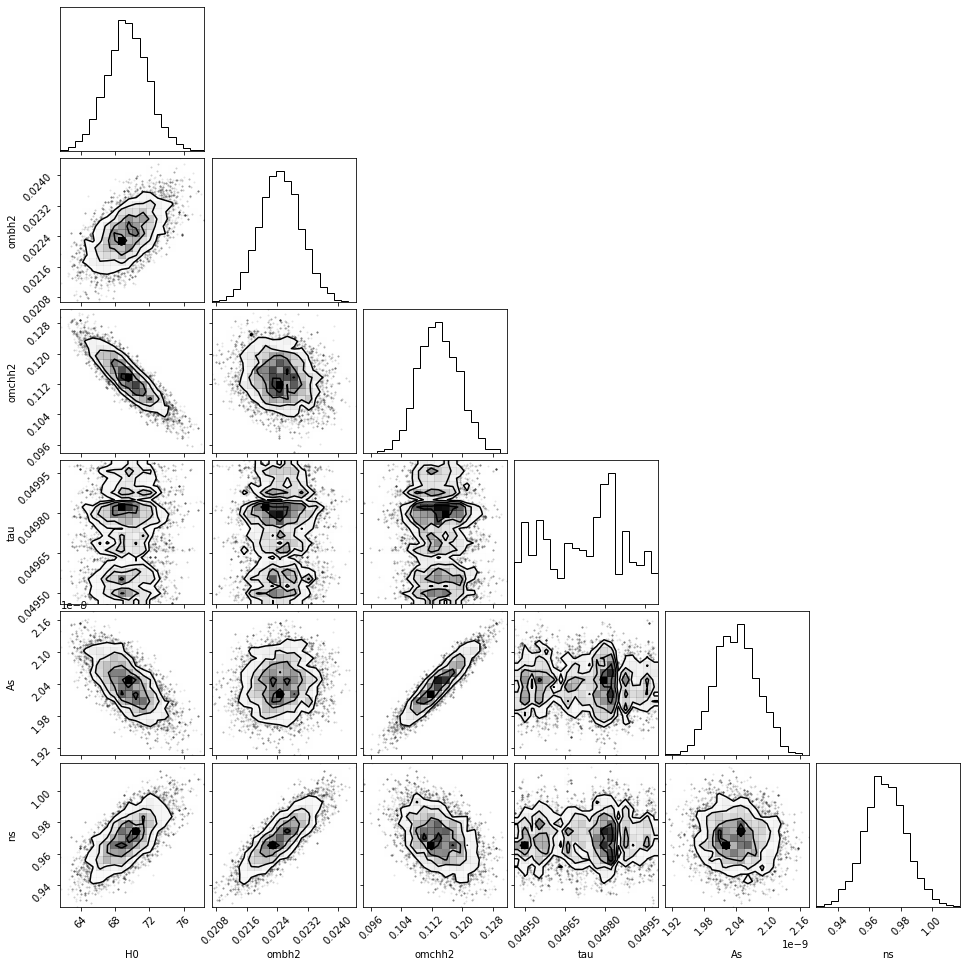

In [77]:
figure = corner.corner(chain2, labels = labels)
plt.show()

In [104]:
print_results(chain2)

H0 | mean: 69.42 , std: 2.392 , parameter limits: [64.68, 74.28]
ombh2 | mean: 0.02248 , std: 0.0005456 , parameter limits: [0.02146, 0.02356]
omchh2 | mean: 0.1137 , std: 0.005125 , parameter limits: [0.1038, 0.1241]
tau | mean: 0.04973 , std: 4.083e-05 , parameter limits: [0.04948, 0.04997]
As | mean: 2.04e-09 , std: 3.748e-11 , parameter limits: [1.965e-09, 2.118e-09]
ns | mean: 0.97 , std: 0.01395 , parameter limits: [0.944, 0.9966]


For this chain, we can provide tau sigma and 95% confidence interval (tau mean +- 2 sigma) from the prior itself.

To importance sample the first chain, we would do it like this:

In [95]:
def weight(chain, par_ind, prior):  # prior has to be a tuple (mean, variance)
    weights = np.exp(-(chain[:, par_ind]-prior[0])**2/2/prior[1]**2)  #weight is the Gaussian likelihood of a given tau
    weighted_means = np.zeros(chain.shape[1])
    weighted_errs = np.zeros(chain.shape[1])
    for i in range(chain.shape[1]):
        # use weighted average for mean and variance
        weighted_means[i] = np.sum(weights*chain[:,i])/np.sum(weights)  
        weighted_errs[i] = np.sqrt(np.sum((chain[:,i] - weighted_means[i])**2*weights)/np.sum(weights))
        print(labels[i],'| mean:',float('%.3e'% weighted_means[i]), ', std:',float('%.3e'% weighted_errs[i]) )
weight(chain1, 3, (0.0544,0.0073))

H0 | mean: 69.51 , std: 2.392
ombh2 | mean: 0.02254 , std: 0.0005456
omchh2 | mean: 0.1139 , std: 0.005126
tau | mean: 0.05011 , std: 4.085e-05
As | mean: 2.044e-09 , std: 3.748e-11
ns | mean: 0.9711 , std: 0.01395


But it does not work here, as the tau chain in chain1 is not converged, and the tau values are all very similar and far from the maximum of the prior distribution. So we are simply getting almost identical weights for each sample, so the results remain largely unchanged.

As has been said, we do not expect a good result for tau from fitting these data. But the results presented here can be improved if $\tau$ explores much more of its phase space (by running a longer chain and/or increasing the tau step size).